## Analyze A/B Test Results run by an e-commerce website

## Table of Contents
- [Introduction](#intro)
- [Start the data analysis](#start)
- [Part I - General probability](#probability)<br>
&nbsp;&nbsp;&nbsp;&nbsp;General properties <br>
&nbsp;&nbsp;&nbsp;&nbsp;Cleaning data and creation of a new dataframe <br>
&nbsp;&nbsp;&nbsp;&nbsp;Probability calculation <br>
&nbsp;&nbsp;&nbsp;&nbsp;Observations from the probabilities <br>
- [Part II - A/B Test by hypothesis testing](#hypothesis) <br>
&nbsp;&nbsp;&nbsp;&nbsp;Hypothesis<br>
&nbsp;&nbsp;&nbsp;&nbsp;Each page conversion proportion under the null <br>
&nbsp;&nbsp;&nbsp;&nbsp;Sampling distribution over 10 000 iterations to estimate from the null <br>
&nbsp;&nbsp;&nbsp;&nbsp;Conclusion from hypothesis testing <br>
- [Part III - A/B Test by statistical test z-test](#ztest)<br>
&nbsp;&nbsp;&nbsp;&nbsp;Calculation of z-test result and p-value<br>
&nbsp;&nbsp;&nbsp;&nbsp;Conclusion from statistical z-test<br>
- [Part IV - Regression](#regression)<br>
&nbsp;&nbsp;&nbsp;&nbsp;Creation of interception column and dummies column<br>
&nbsp;&nbsp;&nbsp;&nbsp;Creation of linear regression<br>
&nbsp;&nbsp;&nbsp;&nbsp;Conclusion from the linear regression<br>
&nbsp;&nbsp;&nbsp;&nbsp;Considering other factors in the regression model<br>
- [Conclusion of A/B test](#conclusion)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  For this project, I am working to understand the results of an A/B test run by an e-commerce website.  The goal is to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision. The results of the A/B test are analyzed by 3 methods: hypothesis testing and sampling distribution, statistical z-test, and regression.

<a id='start'></a>
### Start the data analysis


In [1]:
#import of libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
#acquire the data into a dataframe and preview
df = pd.read_csv('./original_data/ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


<a id='probability'></a>
### Part I - General probability

#### General Properties
*Which features are available in the dataset and which contains blank, false or duplicated values?*

In [3]:
#number of rows and columns in the dataset
df.shape

(294478, 5)

In [4]:
#number of unique users in the dataset
df.user_id.nunique()

290584

In [5]:
#proportion of users converted
df.converted.mean()

0.11965919355605512

In [6]:
#rows with missing values
df.info() 
#no missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [7]:
#number of times the `new_page` and `treatment` don't line up
df.query('(group == "control" and landing_page == "new_page") or (group == "treatment" and landing_page == "old_page")').user_id.count()

3893

The rows where **treatment** is not aligned with **new_page**, or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  So these rows will be removed.
#### Data Cleaning and creation of a new dataframe

In [8]:
#creation of a new dataframe df2 with rows removed
df2 = df.query('(group == "control" and landing_page != "new_page") or (group == "treatment" and landing_page != "old_page")')
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [9]:
#number of unique user_ids in df2
df2.user_id.nunique()

290584

In [10]:
#identification of one user_id repeated in df2
df2[df2.duplicated('user_id') == True]['user_id']

2893    773192
Name: user_id, dtype: int64

In [11]:
#row information for the repeat user_id
df2.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [12]:
#Remove one of the rows with a duplicate user_id
df2.drop_duplicates('user_id', inplace=True)
#to check if the duplicates disappear
df2.query('user_id == 773192')

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


#### Probability calculation

In [13]:
#probability of an individual converting regardless of the page they receive
df2.converted.mean()

0.11959708724499628

In [14]:
#Given that an individual was in the control group, what is the probability they converted?
p_control_conv = df2[df2['group'] == "control"].converted.mean()
p_control_conv

0.1203863045004612

In [15]:
#Given that an individual was in the treatment group, what is the probability they converted
p_treatment_conv = df2[df2['group'] == "treatment"].converted.mean()
p_treatment_conv

0.11880806551510564

In [16]:
#probability that an individual received the new page?
df2[df2['landing_page'] == "new_page"].user_id.count() / df2.user_id.count()

0.50006194422266881

#### Observation from the proabilities
The probability of receiving the new page or the old page is same, thus the two groups are balanced. Then the conversion rates for the treatment (new_page) and control (old_page) groups are the same, even the old page has a better conversion. For the moment we do not have enough evidence to say that the new page leads to more conversion.

<a id='hypothesis'></a>
### Part II - A/B Test by hypothesis testing 
#### Hypothesis
What are the null and alternative hypotheses if we want to assume that the old page is better unless the new page proves to be definitely better?
The terms of **$p_{old}$** and **$p_{new}$** are the converted rates for the old and new pages.

$$ H_{0} : p_{new}  = p_{old} $$
$$ H_{1} : p_{new} > p_{old}$$
Under the null hypothesis, $p_{new}$ and $p_{old}$ both have success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page.

We decide to have a Type I error rate of 5%.
#### Each page conversion proportion under the null

In [17]:
#obtain the convert rate for p_new under the null
# null hypothesis: the convert rates p_new and p_old are identical to converted success rate regardless the page
p_new_null = df2.query('converted == 1').user_id.nunique() / df2.user_id.nunique()
p_new_null

0.11959708724499628

In [18]:
#obtain the convert rate for p_old under the null
# null hypothesis: the convert rates p_new and p_old are identical to converted success rate regardless the page
p_old_null = p_new_null
p_old_null

0.11959708724499628

In [19]:
#n_new: the number of samples landing on the new page
n_new = df2.query('landing_page == "new_page"').user_id.count()
n_new

145310

In [20]:
#n_old: the number of samples landing on the old page
n_old = df2.query('landing_page == "old_page"').user_id.count()
n_old

145274

In [21]:
#simulate n_new transactions with a proportion rate of p_new, with only 2 issues (binomial)
new_page_converted = np.random.binomial(1, p=p_new_null, size=n_new)

In [22]:
#simulate n_old transactions with a proportion rate of p_old, with only 2 issues (binomial)
old_page_converted = np.random.binomial(1, p=p_old_null, size=n_old)

In [23]:
#get the proportion convertion of new_page_converted
new_page_p = new_page_converted.mean()

#get the proportion convertion of old_page_converted
old_page_p = old_page_converted.mean()

#get the difference
diff = new_page_p - old_page_p
diff

0.0011540283877741753

#### Sampling distribution over 10 000 iterations to estimate from the null

We perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null. 

In [24]:
#simulate sampling distribution with bootstrapping for the difference in proportions 
p_diffs = []

#faster process 
#np.random.binomial(n, p, size) with n = number of draw, p = probability event at any trial, 
#size = number of times run the experiment
new_converted_simulation = np.random.binomial(n_new, p_new_null,  10000)/n_new #directly get the sum and divide by n like mean
old_converted_simulation = np.random.binomial(n_old, p_old_null,  10000)/n_old
p_diffs = new_converted_simulation - old_converted_simulation


#if we follow exactly the same process:
#for _ in range(10000):
    #new_page_converted = np.random.binomial(1, p_new_null, n_new)
    #old_page_converted = np.random.binomial(1, p_old_null, n_old)
    #new_page_p = new_page_converted.mean()
    #old_page_p = old_page_converted.mean()
    #p_diffs.append(new_page_p - old_page_p)

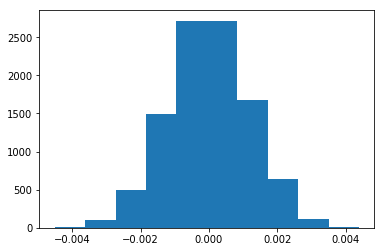

In [25]:
#plot sampling distribution
plt.hist(p_diffs); 
#normal distribution

In [26]:
#get the observed difference from previous steps (in part I)
obs_diff = p_treatment_conv - p_control_conv
obs_diff

-0.0015782389853555567

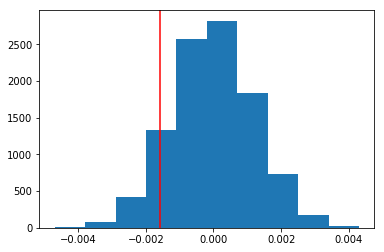

In [27]:
#simulate distribution under the null, random normal distribution centered at 0 with spread and size of sampling distribution
diffs = np.array(p_diffs)
null_vals = np.random.normal(0, diffs.std(), diffs.size)

#plot the null distribution
plt.hist(null_vals);
#plot observed statistic
plt.axvline(x=obs_diff, color='r');


In [28]:
#calcul of p-value(proportion) with H1: (p_new > p_old) 
#proportion of p_diffs greater than the observed difference
(null_vals > obs_diff).mean()

0.90369999999999995

#### Conclusion from hypothesis testing

We just have computed the p-value (0.90). We have decided a Type I error rate of 0.05 ($\alpha$). So p-value > $\alpha$ meaning that we **fail to reject the null hypothesis ($H_{0}$)**. It means that there is **no difference between the two pages**. 

<a id='ztest'></a>
### Part III - A/B Test by statistical test z-test
We could also use a built-in to achieve similar results.
#### Compute z-test result and p-value

In [29]:
#calculate the number of conversions for each page
convert_old = df2.query('landing_page == "old_page" and converted == 1').user_id.count()
convert_new = df2.query('landing_page == "new_page" and converted == 1').user_id.count()

#calculate the number of individuals who received each page
n_old = df2.query('landing_page == "old_page"').user_id.count()
n_new = df2.query('landing_page == "new_page"').user_id.count()
convert_old, convert_new, n_old, n_new

(17489, 17264, 145274, 145310)

In [30]:
# use stats.proportions_ztest to compute test statistic and p-value
# H1: (p_new > p_old) so use of one-tailed test
#number of successes: number of convert (convert_old & convert_new)
#number of observations: number of rows (n_old & n_new)
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
z_score, p_value

(-1.3109241984234394, 0.90505831275902449)

In [31]:
#to get the critical region value with Type I error rate of 0.05
from scipy.stats import norm
norm.ppf(1-0.05)

1.6448536269514722

#### Conclusion from statistical z-test
Here the z-score < limit score for Type I error rate of 0.05 (1.65) and p-value > 0.05 so we **fail to reject the null hypothesis**. This **findings agree with the previous part**.

<a id='regression'></a>
### Part IV - A regression approach
In this final part, we see that the result in the previous parts can also be acheived by performing regression.<br>
We are in a case of only 2 possible outcomes (a conversion or no conversion), so the best regression would be a **logistic regression**.

#### Create interception column and dummies column


In [32]:
#creation of interception column
df2['intercept'] = 1

#create the dummies column with 1 for treatment
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']
df2.head(1)

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0


#### Creation of the linear regression

In [33]:
#creation of the logistic regression
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


In [34]:
#summary of the model
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 20 Feb 2018   Pseudo R-squ.:               8.077e-06
Time:                        14:34:07   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

#### Conclusion from the linear regression
The p-value = 0.190, this value differs from p-value in part II (p-value = 0.90). <br><br>
The p-value is the probability to obtain the statistic (or more extreme) if the null-hypothesis is true.<br><br>
In the **part II the null hypothesis is p_new = p_old and alternative p_new > p_old**. <br>
In a **regression model, the null hypothesis is that β1(slope of y=f(x)) = 0 (no relationship between the response and explanatory variables), while the alternative hypothesis is that β1 ≠ 0**. <br> <br>
The representation of the null hypothesis p_new = p_old of part II is representated with a slope of 1. <br>
If we were in the perfect case of no deviation between population and sample ($\bar{X}$ = $\mu$), the p_partII = 1 but p_partIII = 0 (all point would fit to the slope 1). However if the deviation of the samples are really large, the p_partII = 0 and p_partIII = 1 (the line could have a large variability between slope 1 and slope 0).  Thus, the margin of flexibility  of the slope of regression due to the standard deviation represent the inner part of the sampling distribution of part II (between the two lines of $\bar{X}$). And we realise that p_partII + (p_partIII / 2) = 1 <br><br>
Even if our both p-values are different, both conclusions are that **the conversion rate does not change for the 2 types of pages (old and new)**.

#### Considering other factors in the regression model
As explained in the previous question, the ab_page is not significant to predict if there is a conversion. So other factors could be considered. One disadvantage of new factors could be the fact that the coefficients of the regression are less easy to interpret.

*- The country alone*<br>
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives.  


In [35]:
#importing the countries data
countries_df = pd.read_csv('./original_data/countries.csv')

#join the 2 datatables
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head(1)

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0


In [36]:
#get the different output of country
df_new['country'].unique()

array(['UK', 'US', 'CA'], dtype=object)

In [37]:
#Create the  dummies for country
df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new['country'])
df_new.head(1)

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0


In [38]:
#new regression model with country (baseline CA)
logit_mod2 = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'UK', 'US']])
results2 = logit_mod2.fit()
results2.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Tue, 20 Feb 2018   Pseudo R-squ.:               2.323e-05
Time:                        14:34:11   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
US             0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

**Conclusion:** With the p-values of UK and US, we can say that **`country` is has no impact on the conversion**.

*- Interaction between the country and the page*<br>
Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion. For this reason we will intergrate in our model UK x ab_page and US x ab_page.

In [39]:
#creation of columns UK*ab_page and US*ab_page for interaction term
df_new['UK_abpage'] = df_new['ab_page'] * df_new['UK']
df_new['US_abpage'] = df_new['ab_page'] * df_new['US']
df_new.head(1)

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US,UK_abpage,US_abpage
user_id,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0,0,0


In [40]:
#new regression model with country  and interaction term(baseline CA)
logit_mod3 = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'UK', 'US', 'UK_abpage', 'US_abpage']])
results3 = logit_mod3.fit()
results3.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Tue, 20 Feb 2018   Pseudo R-squ.:               3.482e-05
Time:                        14:34:13   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
UK             0.0118      0.040      0.296      0.767      -0.066       0.090
US             0.0175      0.038      0.465      0.642      -0.056       0.091
UK_abpage      0.0783      0.057      1.378      0.168      -0.033       0.190
US_abpage      0.0469      0.054      0.872      0.383      -0.059       0.152
==============================================================================
"""

**Conclusion:** The interaction term did not improve the model.

<a id='conclusion'></a>
## Conclusion of A/B test
The new page has no impact on the conversion rate. We also have observed that the country has no impact on the conversion rate. So for the e-commerce company should keep the old page.